# NN Test

Visual analysis of the predicted and reference lines. 

> **Note:** MIGRATE THIS NOTEBOOK TO THE "SRC" FOLDER IN ORDER FOR IT TO WORK.

In [182]:
!pip3 install pandas

In [183]:
import os
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from matplotlib.colors import LinearSegmentedColormap
from statistics import mean
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

print(f'current dir: {os.getcwd()}')

from dataloader import *
from pre_process import *
#sys.path.append('../')

# torch.cuda.empty_cache()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

current dir: /home/ubuntu/nn-lidar/IC_NN_Lidar


       "id": "06-04-2024_21-22-37",
        "mean0": -0.004196671800650702,
        "mean1": -0.004196671800650702,
        "mean2": 90.88981001120948,
        "mean3": 135.02487427399674,
        "std0": 0.24400108426220676,
        "std1": 0.24400108426220676,
        "std2": 54.76631030741322,
        "std3": 54.874353288031536

In [184]:
BATCH_SIZE = 40
MODEL_NAME = 'model_06-04-2024_21-22-37.pth'
# hard coded
MEAN = [-0.004196671800650702, -0.004196671800650702, 90.88981001120948, 135.02487427399674]
STD = [0.24400108426220676, 0.24400108426220676, 54.76631030741322, 54.874353288031536]

In [185]:
def getData(csv_path, train_path, batch_size=BATCH_SIZE, num_workers=0):
    ''' get images from the folder (assets/images) and return a DataLoader object '''
    
    dataset = TestNnDataLoader(csv_path, train_path)

    train_size, val_size = int(0.8*len(dataset)), np.ceil(0.2*len(dataset)).astype('int')
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_data = DataLoader(train_dataset, batch_size=train_size, shuffle=True,num_workers=num_workers)
    val_data  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=num_workers)

    # get one image shape from the train_data
    for i, data in enumerate(train_data):
        print(f'images shape: {data["image"].shape}')
        print(f'label length: {len(data["labels"])}')
        break
    print('-'*65)

    print(f'train size: {train_size}, val size: {val_size}')
    return train_data, val_data


#! Navigate back one directory
#!os.chdir('..') 

cwd = os.getcwd()
print("Current working directory:", cwd)


DATASET_ID = '5'
CSV_PATH = f"./data/artificial_data/tags/Artificial_Label_Data{DATASET_ID}.csv"
TRAIN_PATH = f"./data/artificial_data/train{DATASET_ID}/"
train_data, val_data = getData(csv_path=CSV_PATH, train_path=TRAIN_PATH)

Current working directory: /home/ubuntu/nn-lidar/IC_NN_Lidar


images shape: torch.Size([9840, 224, 224])
label length: 3
-----------------------------------------------------------------
train size: 9840, val size: 2460


In [186]:
# test the model with the validation data for one random image
# showing the image and the predicted and real labels
# get the first image from the validation data
for i, data in enumerate(train_data):
    images = data['image']
    labels = data['labels']
    break

In [187]:
# image dimension: (batch, channels, height, width)
images = images.type(torch.float32).to(device)
images = images.unsqueeze(1)

labels = [label.type(torch.float32).to(device) for label in labels]
# convert labels to tensor
labels = torch.stack(labels)
# convert to format: tensor([[value1, value2, value3, value4], [value1, value2, value3, value4], ...])
# this is: labels for each image, "batch" times -> shape: (batch, 4)
labels = labels.permute(1, 0)

In [188]:
############ MODEL ############
#?model = models.resnet18(pretrained=True)
#?model = models.resnet50(pretrained=True)
#?model = EfficientNet.from_pretrained('efficientnet-b0')
#?model = models.vgg16(pretrained=True)
model = models.mobilenet_v2(pretrained=True)

########### EFFICENT NET ###########
# model._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# num_ftrs = model._fc.in_features
# model._fc = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.BatchNorm1d(512),
#     nn.ReLU(inplace=True),
#     nn.Linear(512, 256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(inplace=True),
#     nn.Linear(256, 3)  
# )

########### MOBILE NET ########### 
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# MobileNetV2 uses a different attribute for the classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
nn.Linear(num_ftrs, 512),
nn.BatchNorm1d(512),
nn.ReLU(inplace=True),
nn.Linear(512, 3)
)

########### EFFICENT NET ###########
# model._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# num_ftrs = model._fc.in_features
# model._fc = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.BatchNorm1d(512),
#     nn.ReLU(inplace=True),
#     nn.Linear(512, 256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(inplace=True),
#     nn.Linear(256, 3)  
# )

########### VGG NET 16 ########### 
# model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# # Accessing the classifier part of the VGG16 model
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.BatchNorm1d(512),
#     nn.ReLU(inplace=True),
#     nn.Linear(512, 256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(inplace=True),
#     nn.Linear(256, 3)
# )

########### RESNET ###########
# model = models.resnet18()
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# num_ftrs = model.fc.in_features
# # Adding batch normalization and an additional convolutional layer
# model.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.BatchNorm1d(512),
#     nn.ReLU(inplace=True),
#     nn.Linear(512, 256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(inplace=True),
#     nn.Linear(256, 3)  # Alterado para 3 valores de saída
# )

# Moving the model to the device (GPU/CPU)
# model = model.to(device)
path = os.getcwd() + '/models/' + MODEL_NAME
checkpoint = torch.load(path, map_location=device)  # Load to CPU
model.load_state_dict(checkpoint)
#model.load_state_dict(torch.load(path), map_location=device)
model.eval()

# image it is the first image from the images batch
image = images[0].unsqueeze(0)
# label it is the first label from the labels batch
label = labels[0].unsqueeze(0)

In [189]:
# type of image
print(f'image type: {image.shape}')

# Inicie a contagem de tempo antes da inferência
start_time = time.time()

# get the model predictions
predictions = model(image)

# Encerre a contagem de tempo após a inferência
end_time = time.time()

print('Inference time: {:.4f} ms'.format((end_time - start_time)*1000))

image type: torch.Size([1, 1, 224, 224])
Inference time: 26.7828 ms


In [190]:
# convert the predictions to numpy array
predictions = predictions.to(device).detach().numpy()
# convert the labels to numpy array
label = labels.to(device).detach().numpy()


# convert image to cpu 
image = image.to(device).detach().numpy()
# image it is shape (1, 1, 507, 507), we need to remove the first dimension
image = image[0][0]

# print the predictions and labels
print('predictions:', predictions)
print('label:', label[0])

print('>>> image shape:', image.shape)

predictions: [[-0.2528123   0.23917511  0.26785877]]
label: [-0.30401203  0.41709507  0.14397529]
>>> image shape: (224, 224)


In [191]:
#label = PreProcess.standard_deprocess(image=image, label=label[0].tolist(), mean=MEAN, std=STD)
label = PreProcess.deprocess(image=image, label=label[0].tolist())
predictions = PreProcess.standard_deprocess(image=image, label=predictions[0].tolist(), mean=MEAN, std=STD)

print('label (deprocessed):', label)
print('predictions (deprocessed):', predictions)

supposing m1 = m2
supposing m1 = m2
label (deprocessed): [-5.6712819192560815, -5.6712819192560815, 659.3763868073977, 1062.4903270276232]
predictions (deprocessed): [-15.178388678034995, -15.178388678034995, 1578.3786050890826, 2272.5607371479255]


In [192]:
# line equations explicitly

# get the x coordinates
x = np.arange(0, 224)

# get the slopes and intercepts
m1, m2, b1, b2 = label

# get the x and y coordinates of the lines
y1 = m1*x + b1
y2 = m2*x + b2

# get the slopes and intercepts
m1p, m2p, b1p, b2p = predictions

# get the x and y coordinates of the lines
y1p = m1p*x + b1p
y2p = m2p*x + b2p

print(f'm1: {m1:.2f}, m2: {m2:.2f}, b1: {b1:.2f}, b2: {b2:.2f}')
print(f'm1p: {m1p:.2f}, m2p: {m2p:.2f}, b1p: {b1p:.2f}, b2p: {b2p:.2f}')

m1: -5.67, m2: -5.67, b1: 659.38, b2: 1062.49
m1p: -15.18, m2p: -15.18, b1p: 1578.38, b2p: 2272.56


Calculate the L1 Loss as accuracy metric.


In [193]:
ls = torch.tensor(label).unsqueeze(0)
ps = torch.tensor(predictions).unsqueeze(0)


l1_loss = nn.L1Loss()
for i in range(4):
    loss = l1_loss(ls[0][i], ps[0][i])
    print("L1 Loss:", loss)

L1 Loss: tensor(9.5071)
L1 Loss: tensor(9.5071)
L1 Loss: tensor(919.0023)
L1 Loss: tensor(1210.0704)


findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not

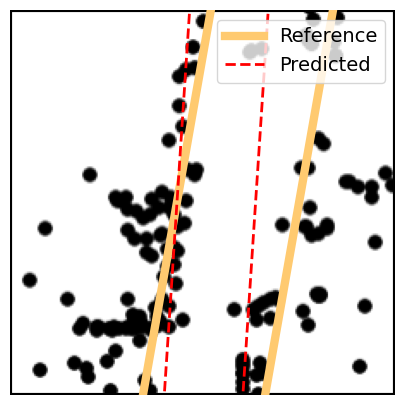

In [194]:
fig, ax = plt.subplots(figsize=(8, 5), frameon=True)

linewidth = 2.5

# plot the lines
ax.plot(x, y1, color='#ffca70', linestyle='-', label='Reference', linewidth=6)
ax.plot(x, y2, color='#ffca70', linestyle='-', linewidth=6)

ax.plot(x, y1p, color='red', linestyle='--',  label='Predicted', linewidth=2)
ax.plot(x, y2p, color='red', linestyle='--', linewidth=2)

#ax.plot(0, 0, 'ro', markersize=20)
#ax.plot(114, 224, 'ks', markersize=30)

# Customize the title
# title_font = {'family': 'Ubuntu', 'color': 'black', 'weight': 'bold', 'size': 18}
# plt.title('Inference Results', fontdict=title_font)

# Add a white rectangle to create a border
border_style = dict(facecolor='none', edgecolor='black', linewidth=3)
ax.add_patch(plt.Rectangle((0, 0), 1, 1, **border_style, transform=ax.transAxes))

#im = ax.imshow(image, cmap='magma', norm=PowerNorm(gamma=16), alpha=0.65)
im = ax.imshow(image, cmap='gray')
ax.axis('off')

# legend
plt.legend(loc='upper right', prop={'size': 14, 'family': 'Ubuntu'})

plt.show()


In [195]:
# import random
# N = 100  # Number of runs

# errors = []  # List to store the errors
# lines_values = []  # List to store the line values
# losses = []

# for _ in range(N):
# # Generate a random number between 1 and 100
#     r = random.randint(1, BATCH_SIZE)

#     image = images[r - 1].unsqueeze(0)
#     label = labels[r - 1].unsqueeze(0)

#     # Perform the inference and get the predictions
#     predictions = model(image)

#     # Convert the predictions to numpy array
#     predictions = predictions.to('cpu').cpu().detach().numpy()

#     # Calculate the error
    
#     label_np = label[0].numpy()  # Convert label tensor to numpy array
#     error = np.mean(np.abs(predictions - label_np))

#     # Store the error and line values
#     errors.append(error)
#     lines_values.append((predictions[0][0], predictions[0][1], predictions[0][2]))

#     loss_temp = list(range(3))
#     l1_loss = nn.L1Loss()
#     for i in range(3):
#         loss = l1_loss(label[0][i], preds[0][i])
#         loss_temp[i] = loss

#     losses.append(loss_temp)


# # Calculate the mean error
# mean_error = np.mean(errors)
# mean_losses = np.mean(losses, axis=0)
# # calculate standard deviation
# std_dev = np.std(errors)
# std_losses = np.std(losses, axis=0)


# print(f'Mean error: {mean_error:.4f} | Standard deviation: {std_dev:.4f}')
# print(f'Mean losses: {mean_losses} | Standard deviation: {std_losses}')

In [196]:
# # Extract the first, second, and third values from the lines_values list
# first_values = [value[0] for value in lines_values]
# second_values = [value[1] for value in lines_values]
# third_values = [value[2] for value in lines_values]

# # Calculate the mean for each set of values
# mean_first = sum(first_values) / len(first_values)
# mean_second = sum(second_values) / len(second_values)
# mean_third = sum(third_values) / len(third_values)

# means = PreProcess.deprocess(image=image, label=[mean_first, mean_second, mean_third])

# print(means)

In [197]:
errors = []  # List to store the errors
lines_values = []  # List to store the line values
losses = []
full_losses = []

print('Dataset id:', DATASET_ID)
print('len images? ', len(images))
for index in range(len(images)):
    image = images[index].unsqueeze(0)
    label = labels[index].unsqueeze(0)

    # Perform the inference and get the predictions
    predictions = model(image)

    # Convert the predictions to numpy array
    predictions = predictions.to(device)
    
    preds_np = predictions.detach().numpy()

    # Calculate the error
    
    label_np = label[0].numpy()  # Convert label tensor to numpy array
    error = np.mean(np.abs(preds_np - label_np))

    # Store the error and line values
    errors.append(error)
    lines_values.append((preds_np[0][0], preds_np[0][1], preds_np[0][2]))

    loss_temp = list(range(3))
    l1_loss = nn.L1Loss()
    for i in range(3):
        loss = l1_loss(label[0][i], predictions[0][i])
        loss_temp[i] = loss.detach().numpy()
    
    full_loss = l1_loss(label, predictions)

    losses.append(loss_temp)
    full_losses.append(full_loss.detach().numpy())


# Calculate the mean error
mean_error = np.mean(errors)
mean_losses = np.mean(losses, axis=0)
mean_full_losses = np.mean(full_losses)
# calculate standard deviation
std_dev = np.std(errors)
std_losses = np.std(losses, axis=0)
std_full_losses = np.std(full_losses)


print(f'[Error] Mean: {mean_error:.4f} | Standard deviation: {std_dev:.4f}')
print(f'[Losses: Mean] {mean_losses} | Standard deviation: {std_losses}')
print(f'[Full Loss] Mean: {mean_full_losses:.4f} | Standard deviation: {std_full_losses:.4f}')

Dataset id: 5
len images?  9840


[Error] Mean: 0.5240 | Standard deviation: 0.3138
[Losses: Mean] [0.5155887  0.54570866 0.5107802 ] | Standard deviation: [0.3475137  0.41180825 0.29529548]
[Full Loss] Mean: 0.5240 | Standard deviation: 0.3138
